# Noise transformation
The purpose of this notebook is to empirically confirm the theoretical linearization of noise from polar voltages and currents to power in Cartesian coordinates. Without loss of generality, multiplication of two noisy polar measurments can be seen as two voltages with a conductance, both voltage and current or two currents with an impedance.

To perform the check, we proceed as follows:

1. we assume to acquire 100,000 different measurements. Thus, we generate 100,000 different values for magnitude and phase for a specific measurements of both current and voltage.
2. we then add Gaussian noise to the measurements in polar coordinates,
3. we multiply the noisy quantities into power and transform it into Cartesian coordinates,
4. finally, we extract the noise in Cartesian coordinate and we normalize it using its theoretical variance.

We want to see that the normalized distribution is Gaussian and that our standardization makes the noise normally distributed with unit standard deviation.

Interestingly, and coherently with what assessed in previous works, we can appreciate how more accurate phase measurements lead to minor discrepancy from a Gaussian distribution. This can be seen by setting `theta_sd` to 0.0001 and 0.01.

## Setup

In [666]:
import time
import sys
import numpy as np
import matplotlib.pyplot as plt

In [667]:
sys.path.append('..')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [668]:
samples = 100000

## MC Samples
Two sets of measurments $x_i = (m_i + \Delta m_i)e^{j(\theta_i + \Delta \theta_i)}$ and $y_i$ similarly are generated. The final measurments set is $S_i = x_i y_i^\star$. Try also with `theta=-1` and `theta_sd=1` and with `theta=-1` and `theta_sd=0.01` and different combinations for both sets.

In [669]:
np.random.seed(11)

m1 = 1
m2 = 1
theta1 = -1*0#-10 * np.pi / 180
theta2 = -1*0#-10 * np.pi / 180

m1_sd = 0.01
m2_sd = 0.01
theta1_sd = 0.01#1 * np.pi / 180
theta2_sd = 0.01#1 * np.pi / 180

m1_var, theta1_var = m1_sd ** 2, theta1_sd ** 2
m2_var, theta2_var = m2_sd ** 2, theta2_sd ** 2

m1_noise = np.random.normal(0, m1_sd, size=samples)
m2_noise = np.random.normal(0, m2_sd, size=samples)
theta1_noise = np.random.normal(0, theta1_sd, size=samples)
theta2_noise = np.random.normal(0, theta2_sd, size=samples)

noisy_x = (m1 + m1_noise) * np.exp(1j * (theta1 + theta1_noise))
noisy_y = (m2 + m2_noise) * np.exp(1j * (theta2 + theta2_noise))
actual_x = m1 * np.exp(1j * theta1)
actual_y = m2 * np.exp(1j * theta2)
noisy_measurements = (m1 + m1_noise) * np.exp(1j * (theta1 + theta1_noise)) * (m2 + m2_noise) * np.exp(- 1j * (theta2 + theta2_noise))
actual_measurements = m1 * np.exp(1j * theta1) * m2 * np.exp(- 1j * theta2)
cartesian_noise = noisy_measurements - actual_measurements

actual_mean = (np.mean(np.real(cartesian_noise)), np.mean(np.imag(cartesian_noise)))
actual_covariance = np.cov(np.real(cartesian_noise), np.imag(cartesian_noise))

In [670]:
actual_mean

(4.6263032849521e-06, -6.67987860589697e-07)

In [671]:
actual_covariance

array([[2.01420081e-04, 3.85093991e-07],
       [3.85093991e-07, 2.00352795e-04]])

## Covariance of the first-order approximation with actual states
From the notes, the noise can be linearized as follows:
${\Delta S} = \varepsilon_{\text{polar}}^\top \left({\begin{array}{*{20}{c}} {\left| {{I_{it}}} \right|}\\{j\left| {{V_{it}}} \right|\left| {{I_{it}}} \right|}\\{\left| {{V_{it}}} \right|}\\{ - j\left| {{V_{it}}} \right|\left| {{I_{it}}} \right|}\end{array}} \right){e^{j\left( {{\theta_{it}} - {{\phi}_{it}}} \right)}} = \varepsilon_{\text{polar}}^\top (H_r + jH_i)$

The covariance matrix can therefore be computed as $\Sigma_S = [H_r, H_i]^\top \Sigma_{\text{polar}} [H_r, H_i]$.

In [672]:
def cov_avg_true_real(x, y, varmx, varax, varmy, varay):
    mx, ax = np.abs(x), np.angle(x)
    my, ay = np.abs(y), np.angle(y)
    return (my*np.cos(ax-ay))**2*varmx + (mx*my*np.sin(ax-ay))**2*varax + (mx*np.cos(ax-ay))**2*varmy + (mx*my*np.sin(ax-ay))**2*varay

def cov_avg_true_imag(x, y, varmx, varax, varmy, varay):
    mx, ax = np.abs(x), np.angle(x)
    my, ay = np.abs(y), np.angle(y)
    return (my*np.sin(ax-ay))**2*varmx + (mx*my*np.cos(ax-ay))**2*varax + (mx*np.sin(ax-ay))**2*varmy + (mx*my*np.cos(ax-ay))**2*varay

def cov_avg_true_real_imag(x, y, varmx, varax, varmy, varay):
    mx, ax = np.abs(x), np.angle(x)
    my, ay = np.abs(y), np.angle(y)
    return np.sin(ax-ay)*np.cos(ax-ay)*(my**2*varmx + mx**2*varmy - mx**2*my**2*(varax + varay))

## Covariance with actual measurements
In theory, the variables x and y can directly be used to compute $H_i$ and $H_r$.

In [673]:
cov_actual_11 = cov_avg_true_real(actual_x, actual_y, m1_var, theta1_var, m2_var, theta2_var)
cov_actual_22 = cov_avg_true_imag(actual_x, actual_y, m1_var, theta1_var, m2_var, theta2_var)
cov_actual_12 = cov_avg_true_real_imag(actual_x, actual_y, m1_var, theta1_var, m2_var, theta2_var)
cov_actual = np.array([[cov_actual_11, cov_actual_12], [cov_actual_12, cov_actual_22]])

cov_actual

array([[0.0002, 0.    ],
       [0.    , 0.0002]])

## Covariance with real measurements
The variables in $H_i$ and $H_r$ are unknown and practically have to be replaced by noisy measurements.

In [674]:
cov_avg_true_11 = cov_avg_true_real(noisy_x, noisy_y, m1_var, theta1_var, m2_var, theta2_var)
cov_avg_true_22 = cov_avg_true_imag(noisy_x, noisy_y, m1_var, theta1_var, m2_var, theta2_var)
cov_avg_true_12 = cov_avg_true_real_imag(noisy_x, noisy_y, m1_var, theta1_var, m2_var, theta2_var)


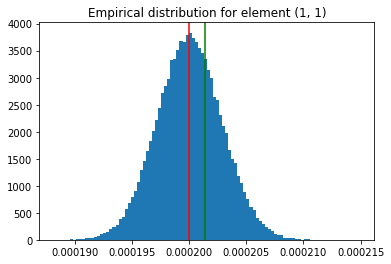

In [675]:
plt.hist(cov_avg_true_11, bins = 100)
plt.title('Empirical distribution for element (1, 1)')
plt.axvline(actual_covariance[0, 0], color='green');
plt.axvline(cov_actual[0, 0], color='red');

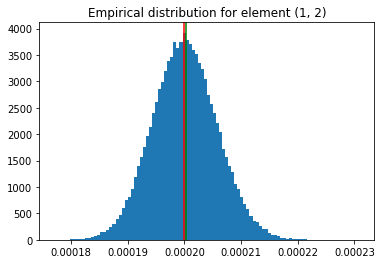

In [676]:
plt.hist(cov_avg_true_22, bins = 100)
plt.title('Empirical distribution for element (1, 2)')
plt.axvline(actual_covariance[1, 1], color='green');
plt.axvline(cov_actual[1, 1], color='red');

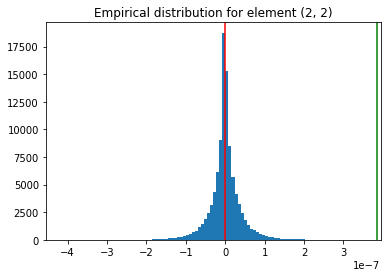

In [677]:
plt.hist(cov_avg_true_12, bins = 100)
plt.title('Empirical distribution for element (2, 2)')
plt.axvline(actual_covariance[0, 1], color='green');
plt.axvline(cov_actual[0, 1], color='red');